In [1]:
# setup
library(reshape2)
library(magrittr)
library(dplyr)
library(ggplot2)
library(viridis)
library(stringr)

DATA.DIR = '../data/'

tellme = function(x){
    read.csv(paste0(DATA.DIR,'/police_stop_data_dictionary.csv')) %>%
        filter(Column.Name==x) %>%
        select(Description) %>%
        return
}

app.key.list = function(n){
    key = paste0('rpt',as.character(n))
    data %>% select(starts_with(key)) %>% names %>% return
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: viridisLite


## Introduction
On May 1, 2019 the Boulder Police Department (BDP) [released a (cleaned and processed) dataset](https://www.denverpost.com/2019/05/01/people-of-color-arrests-boulder-police-stop/) containing data on all *discretionary* stops made by Boulder police in 2018. Discretionary stops make up only a fraction of Boulder police activity, with the vast majority of police interactions being *non-discretionary*, eg. where an officer was dispatched based on a 911 call. Approximately 66,400 police interactions are non-discretionary (per an in-person workshop on the data organized by the City of Boulder on May 6, 2019), whereas 8,209 are discretionary. 

The data were compiled on the recommendation of the consulting firm Hillard Heintz, who in 2016 were hired to perform an internal study of arrest and citation activity within BPD. The [official report](https://bouldercolorado.gov/police/stop-data-information) released by the city has a few high-level takeaways:
1. The report represents only a single year of data and "cannot yet be put into context" (ie. trending up or down)
2. Small data sizes mean that small changes in stop or citation number may have meaningful effects in data trends
3. Laws and policies regulating discretionary action can have "significant positive effects", but will require coordinated action
4. Racial differences in stop rates differ by base population (eg. residents vs nonresidents) 

In my own analysis of the data I generally found these summaries to be, but conservative descriptors of what the data shows. I find strong evidence that racial bias is occurring in the discretionary stops of Boulder police. Even if the bias is currently trending downwards, in 2018 it was a sizeable and urgent problem. If BPD were to stop black individuals at the same rate as white individuals (relative to the base population estimates given in the report) it would have constituted 220 fewer stops in 2018 (just over 2% of the stops in the data).

Breaking down the stop data by "stop reason" highlights some of the reasons why this bias occurs in the top-level. Black individuals are stopped more frequently than white individuals in every type of stop except "welfare checks", where BPD white individuals.  In addition I find that black individuals who are searched for contraband are less likely to have it than their white counterparts. While my methods are not strictly limited to white or black individuals, due to small sample sizes regarding other folks it can be hard to draw conclusions about bias. 

### Front Matter
Data analysis qualifies as activism only in so far as it leads to material change for the subjects of that analysis; anything else is rubbernecking. While I am glad that BPD have released this data and taken real steps towards improved transparency, this is really only the beginning of the process and is meaningless if it doesn't lead to serious changes in their day-to-day operations and procedures.

Before you read anything further I also am going to ask that you read Candice Lanius' excellent essay ["Your Demand for Statistical Proof is Racist"](https://thesocietypages.org/cyborgology/2015/01/12/fact-check-your-demand-for-statistical-proof-is-racist/). To quote:

>Perhaps statistics should be considered a technology of mistrust—statistics are used when personal experience is in doubt because the analyst has no intimate knowledge of it. Statistics are consistently used as a technology of the educated elite to discuss the lower classes and subaltern populations, those individuals that are considered unknowable and untrustworthy of delivering their own accounts of their daily life. A demand for statistical proof is blatant distrust of someone’s lived experience. The very demand for statistical proof is otherizing because it defines the subject as an outsider, not worthy of the benefit of the doubt.

In short: nothing here is new, and if this analysis is the thing that changes your opinions on racial police activity in America then you're probably (a) not paying attention and (b) disregarding the lived experiences of your fellow Americans. Black lives matter.

### About the Data
The original data is broken into two files: `police_stop_data_main_2018.csv` and `police_stop_data_results_2018.csv`. The first dataset contains a row for every individual discretionary stop made by Boulder PD. Let's see what columns the data includes:

In [125]:
'police_stop_data_main_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

 [1] "stopdate"      "stoptime"      "streetnbr"     "streetdir"    
 [5] "street"        "Min"           "sex"           "race"         
 [9] "ethnic"        "Year.of.birth" "enfaction"     "rpmainid"     


We see columns for stop date, time, and duration (in minutes), as well as for race, ethnicity, and sex of the stopped individual **as percieved by the reporting officer**. We also have columns `enfaction`, which indicates if the stopped individual was a resident of Boulder or not, and an `rpmainid`, which links each row to data in the second dataset.

The structure of `police_stop_data_results_2018.csv` is slightly more complex. This file contains information on the stops listed in the `main` dataset, as well as any potential outcomes of each. Let's see what columns it has:

In [3]:
'police_stop_data_results_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

[1] "appkey"   "appid"    "itemcode" "itemdesc" "addtime" 


The `appid` column is used to link rows in `results` to rows in `main` (through the `rpmainid` column in `main`). A big difference here is that each value of `rpmainid` appears only once in `main`, whereas a single `appid` might be listed in multiple rows in `results`, corresponding to multiple outcomes of the same stop. The `appkey` column contains one of seven different values, 'RPT1' through 'RPT7', which indicate what kind of information is contained in the row:

| Appkey | Data              |
|--------|-------------------|
| RPT1   | Stop type         |
| RPT2   | Stop reason       |
| RPT3   | Search conducted  |
| RPT4   |  Search authority |
| RPT5   |  Contraband found |
| RPT6   | Result of stop    |
| RPT7   |  Charge issued    |


The corresponding info is then stored in `itemdesc`. Each pair of `appid` and `appkey` might be listed in multiple rows, eg. if there's more than one reason for the stop. This is not a very convenient data stucture. It would be far better if all of the information was present in a single dataset, and if each row corresponded to exactly one stop (ie. if the data was "tidy"). Fortunately my friend [Sam](https://github.com/samzhang111) has gone ahead and [tidied]() the data. This basically swings the each `appkey`/`infodesc` pair out into its own column, with a 1 in that colum indicating that the `appkey` for that stop had the `infodesc` value. For example, if in the un-tidied data one row has an `appkey` of "rpt1" and an `infodesc` of "pedestrian" that gets converted into a "1" under the column `rpt1.pedestrian`. Let's see what this looks like...

In [87]:
dat = read.csv(paste0(DATA.DIR,'tidy.csv')) %>% set_colnames(tolower(names(.)))
# do a little cleaning data cleaning and combine columns
dat %<>% mutate(raceethn=ifelse(ethnic=='H',race%>%paste0('H'), race%>%as.character))
dat %<>% mutate(rpt2.traffic.speeding= rpt2.speeding | rpt2.traffic.speeding ) %>% select(-rpt2.speeding)
dat %<>% mutate(rpt2.traffic.right.of.way.violation= rpt2.right.of.way.violation | rpt2.traffic.right.of.way.violation ) %>% select(-rpt2.right.of.way.violation)
dat$traffic.stop = dat %>% select(starts_with('rpt2.traffic')) %>% apply(1,any)
dat %>% names %>% print

 [1] "stopdate"                            "stoptime"                           
 [3] "streetnbr"                           "streetdir"                          
 [5] "street"                              "min"                                
 [7] "sex"                                 "race"                               
 [9] "ethnic"                              "year.of.birth"                      
[11] "enfaction"                           "rpmainid"                           
[13] "raceethn"                            "rpt1.pedestrian"                    
[15] "rpt1.vehicle"                        "rpt2.disturbance"                   
[17] "rpt2.equipment.violation"            "rpt2.municipal.violation"           
[19] "rpt2.noise.violation"                "rpt2.state.violation"               
[21] "rpt2.suspicious"                     "rpt2.traffic.parking.violation"     
[23] "rpt2.traffic.reckless.careless"      "rpt2.traffic.reddi.observed.pc"     
[25] "rpt2.traffic.right.of.

This clearly produces a lot of columns (one column for every possible pair of `appkey` and `infodesc`). Nevertheless this format will be very convenient going forward. Let's see the first few rows just of the "rpt2" information (which corresponds to the stop reason):

In [132]:
dat %>% select(starts_with('rpt2')) %>% head

rpt2.disturbance,rpt2.equipment.violation,rpt2.municipal.violation,rpt2.noise.violation,rpt2.state.violation,rpt2.suspicious,rpt2.traffic.parking.violation,rpt2.traffic.reckless.careless,rpt2.traffic.reddi.observed.pc,rpt2.traffic.right.of.way.violation,rpt2.traffic.speeding,rpt2.welfare.check
0,0,0,0,0,0,0,0,0,FALSE,TRUE,0
0,0,0,0,0,0,0,1,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0
0,0,1,0,0,0,0,0,0,FALSE,FALSE,0


A few of the columns are "TRUE/FALSE" coded instead of "1/0" coded, but this makes no difference. R treats them as the same thing:

In [136]:
TRUE == 1
FALSE == 0
TRUE + TRUE
1 + FALSE

[1] TRUE

[1] TRUE

[1] 2

[1] 1

### Analysis Methodology
In this analysis we're going to want to estimate the probability that certain things occur, eg. "what's the probability that a stop occurred because someone was 'suspicious'?". I'm going to estimate these probabilities using the Bayesian methodology. The basic approach here is to find a probability distribution *over probabilities*. That is, given some set binary yes/no observations, we're going to construct what's called the "posterior distribution" over possible values of the probability of a "yes". 

The practical upshot of this is that, for any given "Event" (eg. someone getting searched) we're going to get a boxplot over the probability of that event occuring. The median of the boxplot is going to be our "point estimate" of that probability, and the quantiles of the boxplot are going to give us our error bars. When those boxplots exhibit separation across races, it's indicative of racial bias in the event probabilities.

The theory underlying all of this is (interesting, but) complicated and we're not going to go into it here. The advantage is that it's a lot more flexible and intuitive (after some reading) than the usual "p-value statistics" you may have learned in Stats 101. For our purposes the qualitative conclusions drawn are broadly the same (although I leave the verification of that fact as an exercise to the reader).

Using quantiles as value column: use value.var to override.


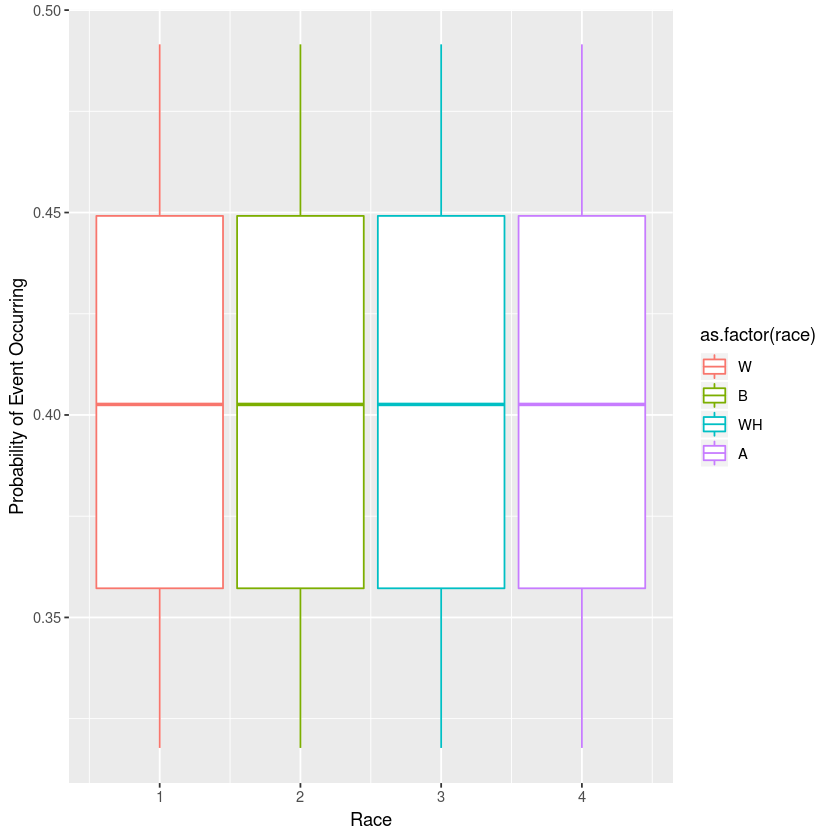

In [131]:
# DEFINE HELPER FUNCTIONS 
    # posterior quantiles given binomial likelihood and beta prior                              
binom.posterior = function(q, outcome_vec, pr.alpha=1, pr.beta=1){
    q %>% qbeta(pr.alpha + sum(outcome_vec), pr.beta + length(outcome_vec) - sum(outcome_vec)) %>%
        return
}
    # wrapper function to create boxplots
plot.posterior = function(post,race.cutoff=100){    
    q = c(.1,.25,.50,.75,.9)
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
            select(raceethn) %>%
            unique %>% unlist %>% as.character
    
    not.all.zero = function(x){!all(x==0)}
    plot.df = sapply(races, function(r){q %>% post(r)}) %>% as.data.frame %>%
    set_colnames(races) %>% select_if(not.all.zero)

    plot.df$q = q
    plot.df %<>%  melt('q') %>% set_colnames(c('q','race','quantiles')) %>% dcast(race ~ q ) 
    plot.df %<>% set_colnames(c('race','y0','y25','y50','y75','y100'))
    plot.df$x = as.numeric(plot.df$race)
    p = ggplot( plot.df, aes(x=x,group=as.factor(race), color=as.factor(race)) ) +
        geom_boxplot( aes(ymin = y0, 
                          lower = y25, 
                          middle = y50, 
                          upper = y75, 
                          ymax = y100), stat = "identity") +
        xlab('Race') + ylab('Posterior Density')
    p %>% return
}

# a quick example of the output of this methodology
test.outcome = rbinom(50,1,.4)
test.post = function(q,r) {binom.posterior(q,test.outcome)}
plot.posterior(test.post, race.cutoff=100) + ylab('Probability of Event Occurring')

In the above example we draw 50 yes/no samples of an event that occurs "yes" with 40% probability. I then plot the Bayesian estimate of this probability, just repeating the same estimate for several races in the dataset. We see that the media of the boxplot is just about at $40$%, with error bars at $\pm 5$% (representing a 50% credible interval) 

## Data Analysis
### Assessing Top-Level Bias
A key challenge in assessing bias in top-level stop rates is the so-called "denominator problem": if X% of individuals stopped were of race R we typically want to know whether this number reflects the underlying demographics of the policed population. If race R is Y% of the population and Y << X then this indicates that race R is being over-policed, or vice versa. The City of Boulder did a lot of work estimating demographic information about the policed population of Boulder, which includes residents, students, people experiencing homelessness, and non-residents who commute for work. A closer look at this work can be found in their [2018 Annual Report](https://bouldercolorado.gov/police/stop-data-information). For our purposes we're just going to pull their population totals and demographic breakdown information and enter it manually.

In [38]:
pop.totals = c(106271,34510,21001,1960)
white.percent = c(.879,.659,.687,.631)
black.percent = c(.011,.025,.027,.074)
asian.percent = c(.053,.078,.039,.006)
indig.percent = c(.003,.016,.009,.028)

demography.df = data.frame(race=c('white'))

race.totals = c(sum(white.percent*pop.totals),
                sum(indig.percent*pop.totals),
                sum(black.percent*pop.totals),
                sum(asian.percent*pop.totals)
    ) %>% rev
race.percent = round(race.totals/sum(race.totals),2)

To measure top level stop rates by race we can simply count the number of occurences of each race in the `race` column of the tidied data (recall that each row of the tidied data corresponds to a single unique stop). Note that a single individual may have been stopped multiple time, and in that case would appear as two or more rows in the tidied data.

In [137]:
stop.breakdown = dat %>% filter(race=='W'|race=='B'|race=='A'|race=='I') %>%
group_by(race) %>% 
summarize(Stops=n(),
          Percent=round(n()/nrow(dat),2)) %>%
mutate('Pop Percent'=race.percent, 
       'Pop Total'=race.totals)
stop.breakdown

race,Stops,Percent,Pop Percent,Pop Total
A,310,0.04,0.06,9154.942
B,353,0.04,0.02,2743.798
I,36,0.00,0.01,1114.862
W,7425,0.90,0.91,131818.746


As indicated in the Annual Report, there does appear to be some mismatch between stop rates and demographic representation. But just from this table it's not clear if these differences are meaningful, or if they just represent noise. We can use the Bayesian approach to address this. By plotting the posterior density over the probability of being in the stop dataset by race we can get a sense of whether these differences are meaningful. 

Using quantiles as value column: use value.var to override.


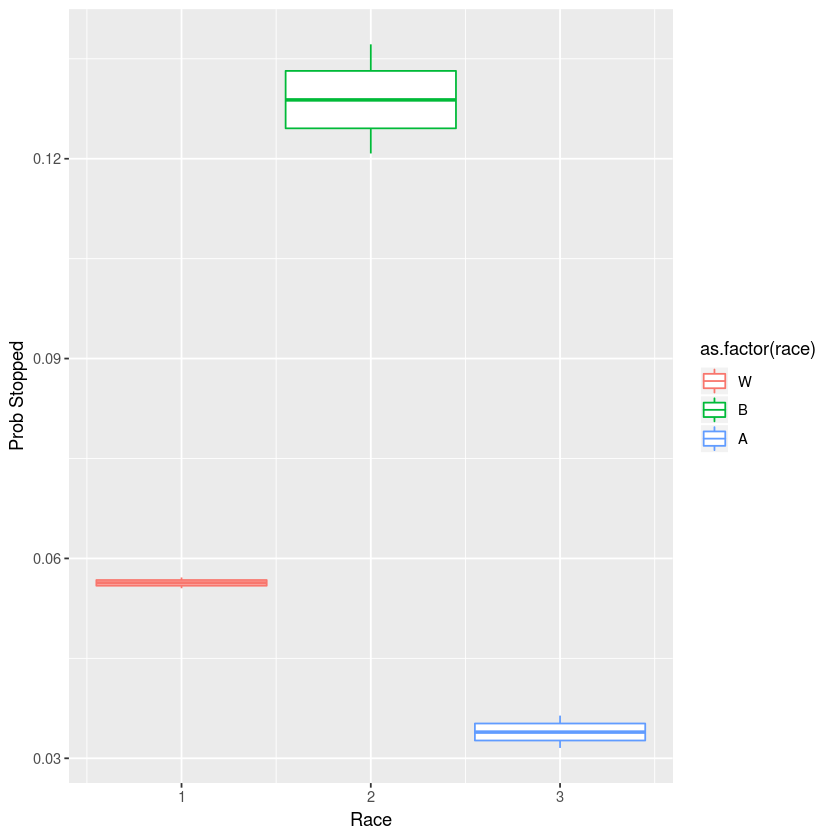

In [117]:
top.stop.posterior = function(q,r){
    if (r == 'WH') { return(0.0) }
    
    n = stop.breakdown %>% filter(race==r) %>% 
    select('Pop Total') %>% unlist %>% as.numeric
    
    stopped = stop.breakdown %>% filter(race==r) %>% 
    select(Stops) %>% unlist %>% as.numeric
    
    a = 1 + stopped
    b = 1 + n - stopped

    return( qbeta(q,a,b) )    

}

plot.posterior(top.stop.posterior,race.cutoff=100) + ylab('Prob Stopped')

Since the posterior densities exhibit substantial amounts of separation it's pretty clear that there are *big* racial differences between the probabilities of experiencing a discretionary stop. Asian individuals seem to have similar, low probability of being stopped, relative to white individuals. On the other hand, black individuals are *substantially* more likely to be included in this data, and there appears to be no overlap with the other posterior densities. This is pretty clear evidence that race has some kind of effect on police stop rates. Let's dig in on why this might be the case.

### Most racialized search reason?
What accounts for this difference in stop rates? Every stop lists a reason for why the officier initiated the stop. Some of the given reasons seem especially likely to be exhibit differences across races (eg. "suspicious"). Given this, we might ask "what stop reason shows the most variability across races?" To answer this question we can perform some Bayesian hypothesis testing. For a given stop reason, we'll compare the hypothesis that all races have the **same** probability of being stopped with this reason ($H_0$, "no bias") to the hypothesis that all races have **different** probabilities of being stopped for this reason ($H_1$, "bias"). To perform this test we'll use the Bayes factor (BF), which is defined as $\frac{\text{Pr}[H_1|D]}{\text{Pr}[H_0|D]}$, where $D$ is the collected data. When the BF >> 1 then we conclude that the data strongly favors $H_1$, which in our case indicates unequal treatment across races. Since BFs tend have an extreme order of magnitude, we'll instead work on the log scale to prevent numerical problems.

However BF alone may not capture precisely what we want. The BF may indicate that a racial bias clearly exists, but that size of that bias may be very small. Let's therefore define a loose "racialization" metric as the log BF (scaled by the maximum log BF across all stop reasons) multiplied by the median difference between Black and White stop rates for that reason (in units of "extra individuals stopped", normalized again by the max value). When this index is positive and large it indicates a potential source of the difference in top-level stop rates.

In [138]:
ln.beta.approx = function(a,b){
    ret = log(beta(a,b))
    if (abs(ret)<Inf){
        return(ret)
    }
    
    ret = .5*log(2*pi) + (a-.5)*log(a) + (b-.5)*log(b) - (a+b-.5)*log(a+b)
    
}

ln.binom.approx = function(n,k){
    ret = log(choose(n,k))
    
    if (ret<Inf){ return(ret) }
    
    ret = .5*log(n) - .5*log(2*pi*k*(n-k)) + n*log(n) - k*log(k) - (n-k)*log(n-k)
    return(ret)
}

bayes.factor.by.stop.reason = function(itemdesc, res=NULL, race.cutoff=200){ 
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
    select(raceethn) %>% unique %>% unlist
    
    races = c('B','W')

    numer.terms = c()
    for (i in 1:length(races)){
        race = races[i]
        
        if (is.null(res)){
            outcome = dat[dat$raceethn==race,] %>% select(itemdesc) %>% unlist 
            }
        
        else {
            outcome = dat[dat$raceethn==race,] %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist 
        }
        
        n = stop.breakdown[stop.breakdown$race==race, c('Pop Total')] %>% unlist
        k = sum(outcome)
        
        a = 1 + k
        b = 1 + n - k

        numer.terms %<>% append(ln.beta.approx(a,b) + ln.binom.approx(n,k))
    }
    mod1.ln.prD = sum(numer.terms)
    
    if (is.null(res)){
        outcome = dat %>% filter(raceethn=='W'|raceethn=='B') %>% select(itemdesc) %>% unlist
        }
    
    else{
        outcome = dat %>% filter(raceethn=='W'|raceethn=='B') %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist
    }
    
    n = stop.breakdown[, c('Pop Total')] %>% sum
    k = sum(outcome)
    
    a = 1 + n
    b = 1 + n - k
    mod2.ln.prD = ln.beta.approx(a,b) + ln.binom.approx(n,k)
    
    return(mod1.ln.prD - mod2.ln.prD)
    
}

bw.bias.by.stop.reason = function(itemdesc, res=NULL){ 
    races = c('B','W')
    meds = c()
    sizes = c()
    
    for (i in 1:length(races)){
        race = races[i]
        
        if (is.null(res)){
            outcome = dat[dat$raceethn==race,] %>% select(itemdesc) %>% unlist 
            }
        
        else {
            outcome = dat[dat$raceethn==race,] %>% filter(enfaction==res) %>% select(itemdesc) %>% unlist 
        }
        
        n = stop.breakdown[stop.breakdown$race==race, c('Pop Total')] %>% unlist
        k = sum(outcome)
        
        a = 1 + k
        b = 1 + n - k
        
        meds %<>% append(qbeta(.5,a,b))
        sizes %<>% append(n)
        
    }
    return((meds[1]-meds[2])*sizes[1])
    
}


stop.reasons = dat %>% select(starts_with('rpt2')) %>% names

racialized.df = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                           'bayes.factor'=sapply(stop.reasons,bayes.factor.by.stop.reason),
                           'bw.bias'=sapply(stop.reasons,bw.bias.by.stop.reason)
) %>% mutate( racialization=(bayes.factor/max(bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

racialized.df.res = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                               'bayes.factor'=sapply(stop.reasons, function(x) {bayes.factor.by.stop.reason(x,res='Y')}),
                               'bw.bias'=sapply(stop.reasons, function(x) {bw.bias.by.stop.reason(x,res='Y')})
) %>% mutate( racialization=(bayes.factor/max(bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

racialized.df.nonres = data.frame('reason'=(stop.reasons %>%str_remove('rpt2.')),
                               'bayes.factor'=sapply(stop.reasons, function(x) {bayes.factor.by.stop.reason(x,res='N')}),
                               'bw.bias'=sapply(stop.reasons, function(x) {bw.bias.by.stop.reason(x,res='N')})
) %>% mutate( racialization=(bayes.factor/max(bayes.factor))*(bw.bias/max(bw.bias)) ) %>% arrange(-racialization)

print(racialized.df)
print('Extra Stops:')
sum(racialized.df$bw.bias)

                           reason bayes.factor    bw.bias racialization
1             municipal.violation     188861.9 78.5473878   0.941125548
2                traffic.speeding     186791.5 42.1522988   0.499516580
3       traffic.reckless.careless     196768.3 22.8549956   0.285304000
4  traffic.right.of.way.violation     195980.7 22.2313367   0.276407800
5             equipment.violation     195123.4 22.2949612   0.275986302
6                      suspicious     198792.0 16.9806761   0.214153557
7                 state.violation     199305.5  6.2157071   0.078592553
8       traffic.reddi.observed.pc     199920.7  5.8407590   0.074079588
9       traffic.parking.violation     200605.9  2.3882599   0.030394620
10                noise.violation     200676.6  1.5178949   0.019324576
11                    disturbance     200436.7  0.9975681   0.012685021
12                  welfare.check     199936.8 -0.2304922  -0.002923617
[1] "Extra Stops:"


[1] 221.7914

Almost every stop reason in the dataset exhibits a large and significant anti-black bias. In fact, the only time that Boulder PD are more likely to stop a white individual is when performing a "welfare check". Otherwise, over 220 "extra" black individuals are policed per year (ie. 220 folks are subject to discretionary stops who would not have been if black individuals were policed at the same rate as white individuals).

With that said: one type of stop

### Given someone is searched, what's the probability that they have contraband?
A common counterpoint to analyses like the above is that racial differences in stop rates may reflect racial differences in the underlying crime rates, rather than racism. One way that we can test this is performing what's called an outcome test. This idea originated in the economics literature to test loan officers were discriminating against black applicants. The idea there was to look at whether blacks individuals who *did* recieve home loans defaulted at a lower rate than their white counterparts. If the data showed that this was the case (and it did), then it indicated that the loan officers were holding black applicants to a higher standard than white applicants. We can apply a similar logic here, and look at the rates at which police searches turn up contraband. If black individuals who are searched are *less* likely to have contraband than white individuals who are searched, then it suggests that police are searching black individuals with a lower threshold of evidence, ie. that racial animus is probably a factor in their decision to search. Let's plot the posterior density over the probability that, given someone is searched, the search turns up contraband:

Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


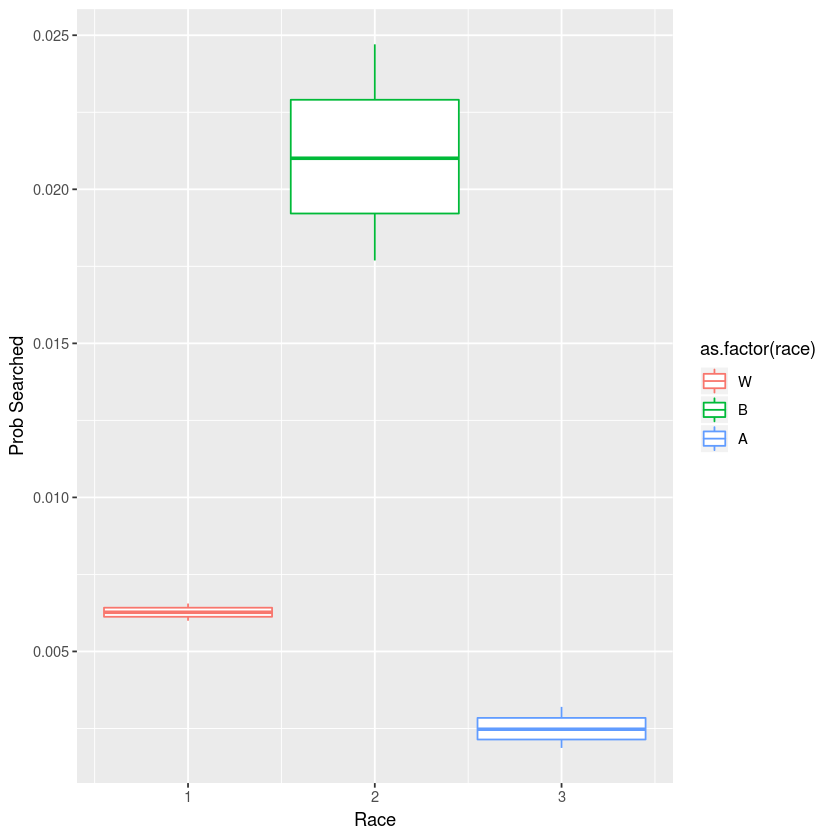

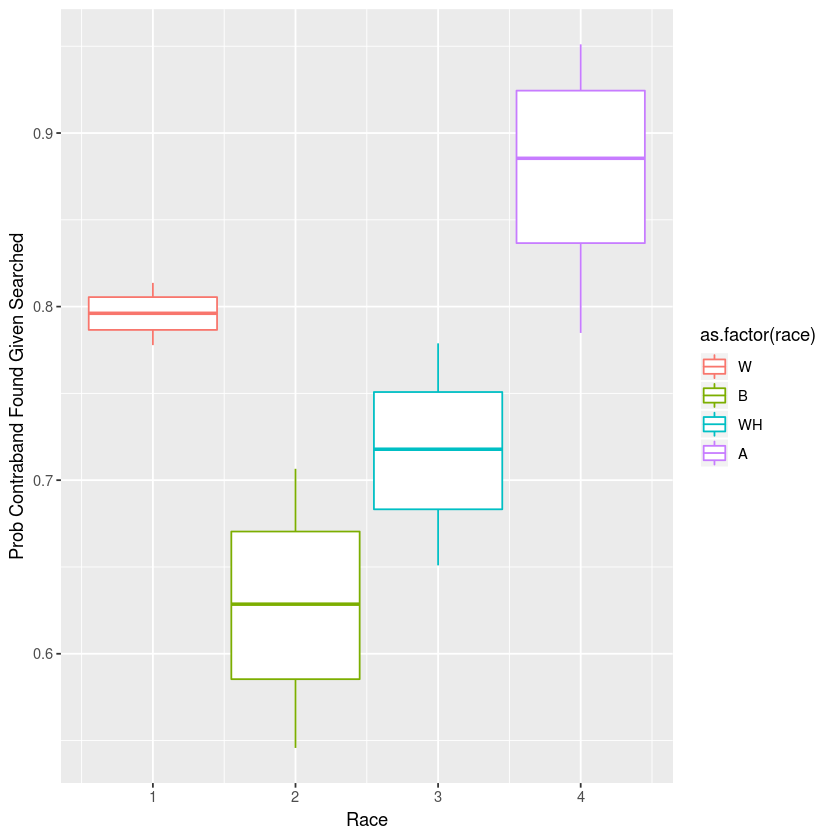

In [113]:
prob.searched.by.race = function(q,r){
        if (r == 'WH') { return(0.0) }
    
        n = stop.breakdown %>% filter(race==r) %>% 
        select('Pop Total') %>% unlist %>% as.numeric
    
        stopped = dat %>% mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>% 
                filter(raceethn==r) %>% select(rpt3.search) %>% unlist %>% sum
    
        a = 1 + stopped
        b = 1 + n - stopped

        return( qbeta(q,a,b) )    
}

prob.cont.given.searched = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.resident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='Y') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.nonresident = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & enfaction=='N') %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.consent = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & rpt4.consent==1) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

prob.cont.given.searched.noconsent = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt3.search==1 & rpt4.consent==0) %>%
                                            select(rpt5.nothing.seized) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

plot.posterior(prob.searched.by.race) + ylab('Prob Searched')
plot.posterior(prob.cont.given.searched) + ylab('Prob Contraband Found Given Searched')


Black individuals are the most likely to be searched, but the least likely to carry contraband (among those searched). The discrepancy in outcome holds for both residents and non-residents, and for consent and non-consent searches. 

### Given someone is speeding, what's the probability they get cited?
According to our analysis, one of the most "racialized" stop reasons was speeding stops. We can apply an outcome test here as well, to asses whether this difference reflects real differences in perpretation rates. An outcome test does struggle here a little, because the outcome is at the stopping officer's discretion. If black drivers are cited less it *could* (technically) be the case that Boulder PD are just more lenient towards black drivers (which seems unlikely, given the discrepancy in contraband rates, a mountain of sociological research, the history of policing in America, and the lived experience of black and brown Americans). A more complete dataset would clarify this ambiguity: if we had access to the recorded driving speed of the stopped drivers we could apply the test to those values, rather than just the binary cited/not cited outcome. A (slightly cludgy) way around this is to do a second outcome test on whether the citations result in charges (ie. whether the ticket was upheld), which gives a slightly roundabout metric of strength of evidence on which the citation was issued. It appears that black drivers who were cited have their tickets dropped more often than other drivers, though the difference is fairly uncertain and not large.

Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


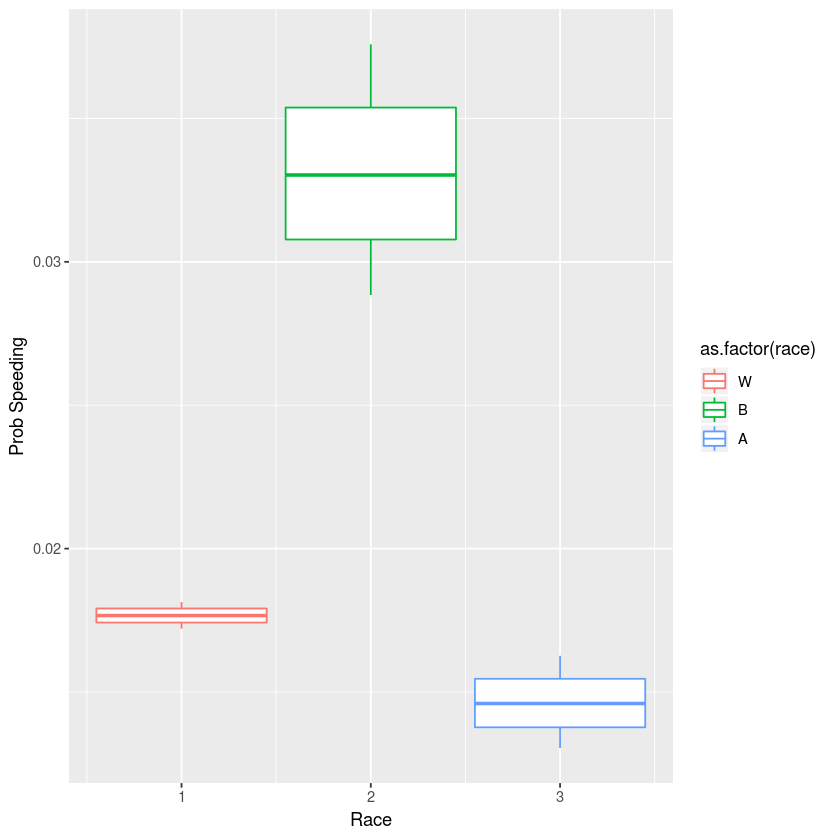

Using quantiles as value column: use value.var to override.


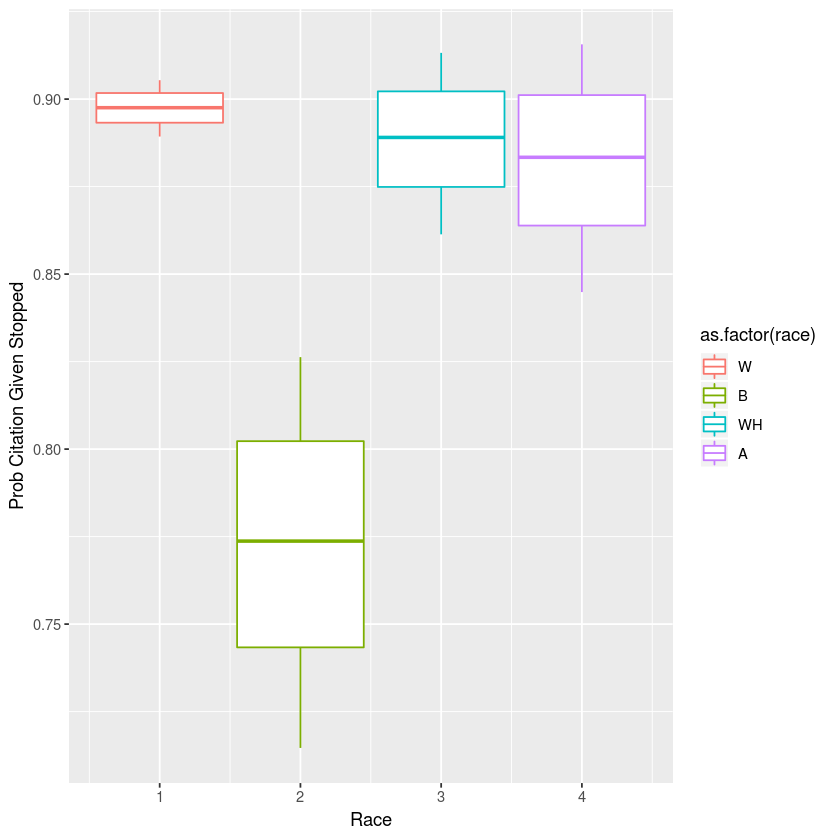

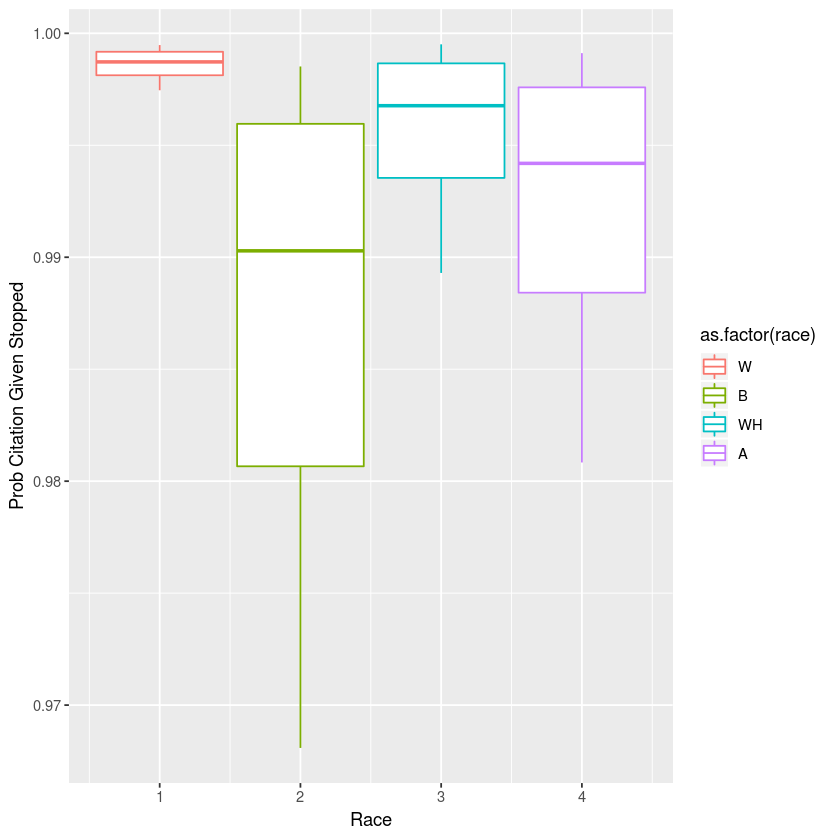

In [114]:
prob.speed.by.race = function(q,r){
        if (r == 'WH') { return(0.0) }
    
        n = stop.breakdown %>% filter(race==r) %>% 
        select('Pop Total') %>% unlist %>% as.numeric
    
        stopped = dat %>% filter(raceethn==r) %>% select(rpt2.traffic.speeding) %>% unlist %>% sum
    
        a = 1 + stopped
        b = 1 + n - stopped

        return( qbeta(q,a,b) )    
}

prob.cite.given.speeding = function(x,r){ dat %>%
                                          filter(raceethn==r & rpt2.traffic.speeding==1) %>%
                                          select(rpt6.citation) %>%
                                          as.matrix %>%
                                          binom.posterior(x,.) %>%
                                          return }

prob.charged.given.cited = function(x,r){ dat %>%
                                            mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                            filter(raceethn==r & rpt2.traffic.speeding==1 & rpt6.citation==1) %>%
                                            select(rpt7.not.charged) %>%
                                            as.matrix %>% `!` %>%
                                            binom.posterior(x,.) %>%
                                            return }

plot.posterior(prob.speed.by.race) + ylab('Prob Speeding')
plot.posterior(prob.cite.given.speeding) + ylab('Prob Citation Given Stopped')
plot.posterior(prob.charged.given.cited) + ylab('Prob Citation Given Stopped')

### Given someone commit a traffic violation, what's the probability they get cited?
Traffic violations more generally exhibit bias against blacks individuals.

Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


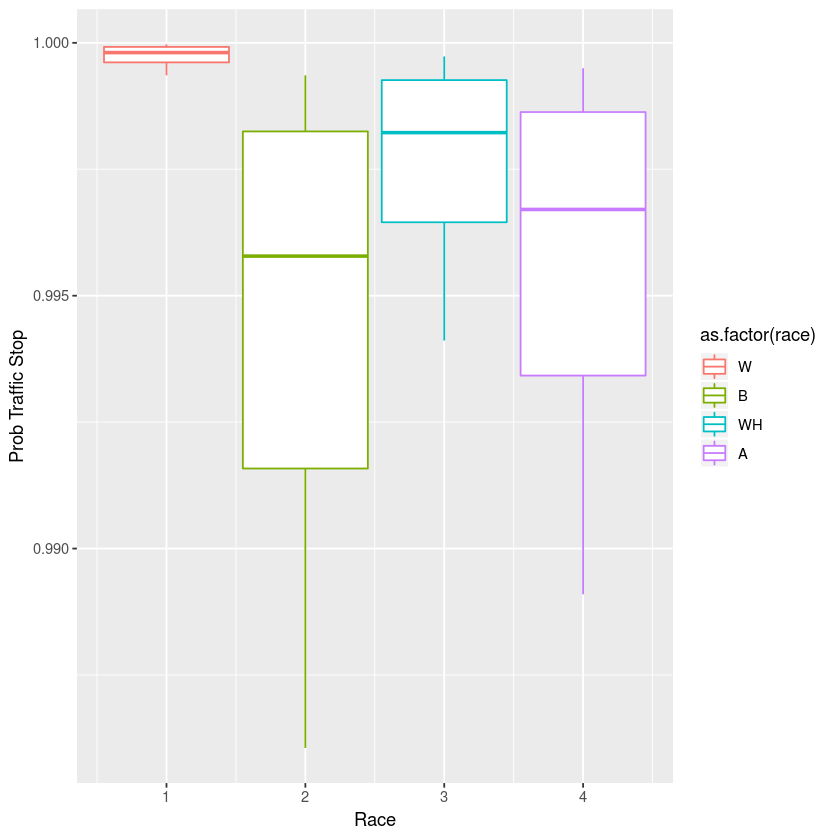

Using quantiles as value column: use value.var to override.


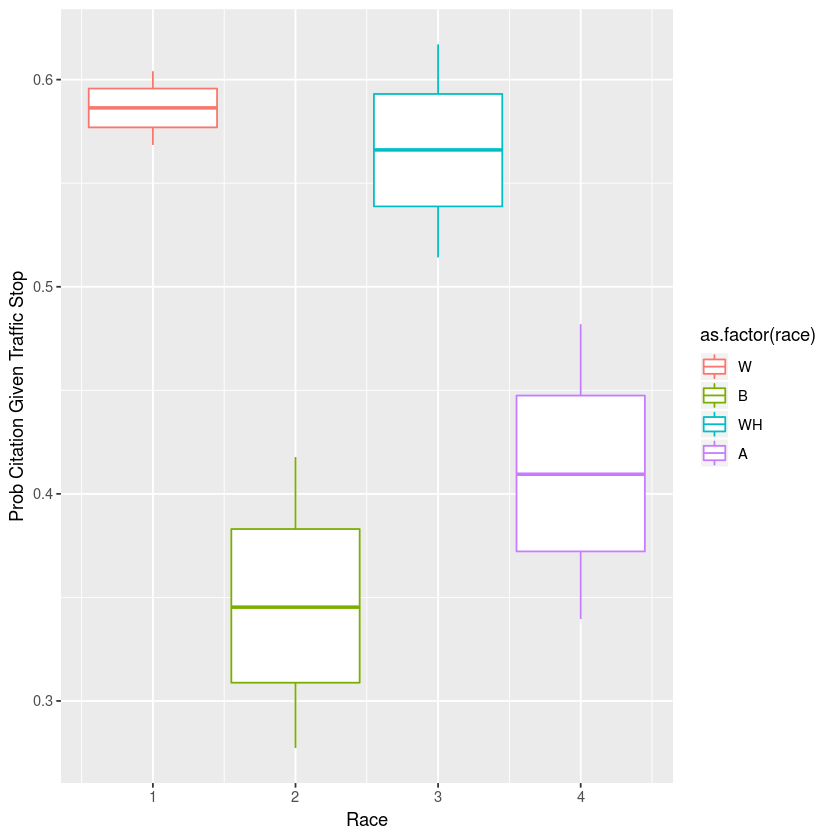

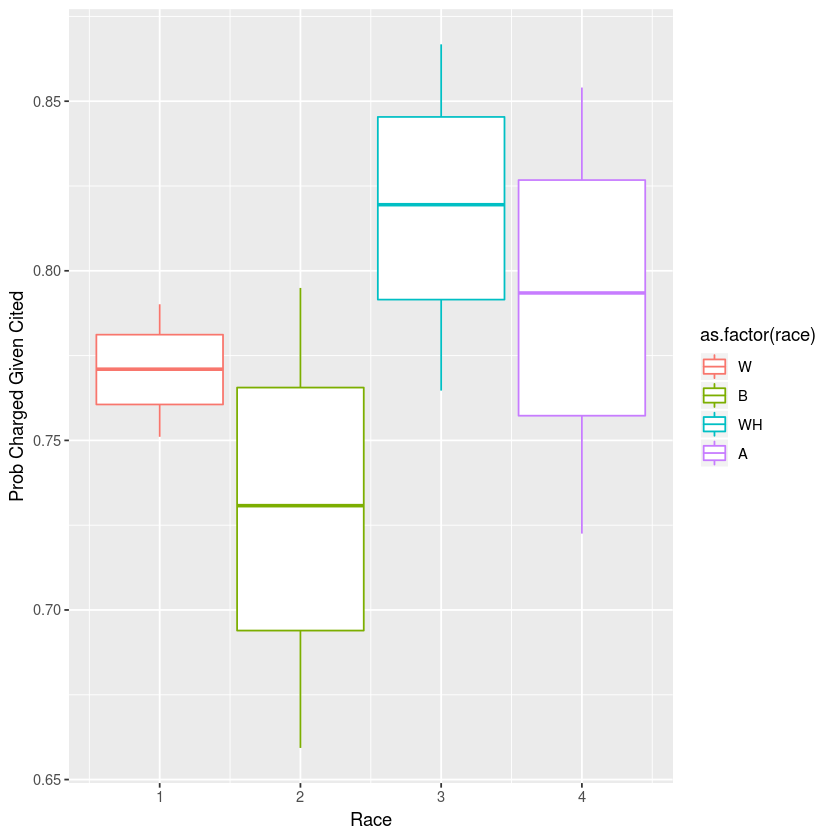

In [83]:
prob.traff.stop.by.race = function(x,r){ dat %>%
                                        filter(raceethn==r & traffic.stop) %>%
                                        select(traffic.stop) %>%
                                        as.matrix %>%
                                        binom.posterior(x,.) %>%
                                        return }

prob.cite.given.traff.stop = function(x,r){ dat %>%
                                          filter(raceethn==r & traffic.stop==1 & rpt2.traffic.speeding==0) %>%
                                          select(rpt6.citation) %>%
                                          as.matrix %>%
                                          binom.posterior(x,.) %>%
                                          return }

prob.charged.given.cited = function(x,r){ dat %>%
                                          filter(raceethn==r & traffic.stop==1 & rpt6.citation==0) %>%
                                          select(rpt7.not.charged) %>%
                                          as.matrix %>% `!` %>%
                                          binom.posterior(x,.) %>%
                                          return }

plot.posterior(prob.traff.stop.by.race) + ylab('Prob Traffic Stop')
plot.posterior(prob.cite.given.traff.stop) + ylab('Prob Citation Given Traffic Stop')
plot.posterior(prob.charged.given.cited) + ylab('Prob Charged Given Cited')




### Appendix: A Caveat
For a given stop reason $S$, let $p_r$ denote "the probability given that someone of race $r$ was stopped in the first place, that they were stopped because of reason $S$". A subtle but important point here (that you may have guessed from the awkward wording in the definition of $p_r$) is that $p_r$ is *not* the same as "the probability that someone of race $r$ was stopped for reason $S$". Let's denote this second probability $\pi_r$. Just using plain english the difference between these two probabilities is a little challenging to grasp. Rewriting the definition of these two quantities using more formal probability notation can help make this difference apparent:
$$
\begin{split}
p_r &= \text{Pr}[\text{reason}=S | \text{race}=r, \text{stopped}=1]\\
\pi_r &= \text{Pr}[\text{reason}=S|\text{race}=r] \\
\end{split}
$$
In probability notation the difference becomes clearer: to measure $\pi_r$ we would need to have data on all the individuals who *could have been stopped for reason S*, but weren't. Unfortunately, by definition of our dataset, these individuals are impossible to observed, and hence we cannot make inference about $\pi_r$ from the discretionary stop data alone. In other words, $p_{r} > p_{r'}$ does not imply that $\pi_r > \pi_{r'}$. Evidence of bias in the discretionary stop data does not necessarily provide evidence of "real" bias, it might be an artifact of the data censoring.

However, if we're willing to bring in the demography data from above and make a few educated guesses it is possible to make some inferences about how bias in the stop data translates to "real" bias. To do so we will leverage the following relationship between $\pi_r$ and $p_r$:
$$
\begin{split}
\pi_r = &p_r \times \text{Pr}[\text{stopped}=1|\text{race}=r] +\\
&\text{Pr}[\text{reason}=S|\text{race}=r, \text{stopped}=0] \times \text{Pr}[\text{stopped}=0|\text{race}=r] \\
\end{split}
$$
Where the quantities $\text{Pr}[\text{stopped}=1|\text{race}=r]$ are our top-level stop rates from above. For simplicity, let's limit our discussion to $r=W$ and $r=B$. Ignoring estimate uncertainty (which is pretty small relative to the point estimates anyways), we have $\text{Pr}[\text{stopped}=1|\text{race}=W] = .06 $ and $\text{Pr}[\text{stopped}=1|\text{race}=B] = .13$. Given these top-level stop rates and for given values of $p_r$, we can ask what relationship between $\text{Pr}[\text{reason}=S|\text{race}=W, \text{stopped}=0]$ and $\text{Pr}[\text{reason}=S|\text{race}=B, \text{stopped}=0]$ would be necessary for $\pi_B = \pi_W$, ie. how often would Boulder PD need to let black individuals "off the hook" (by not stopping them when they could have) for there to be no "'real' bias". If this relationship seems extreme or unlikely to us, we can conclude that biases in $p_r$ indicate biases in $\pi_r$. Here's a simple function to do this:

In [235]:
no.bias.at.probs = function(p.w,p.b){
    lhs = .13*p.b - .06*p.w 

    p.nostop.w = seq(0,1,.001)
    p.nostop.b = (.94/.87)*p.nostop.w - lhs/.87

    return((p.nostop.b/p.nostop.w) %>% median(na.rm=TRUE))    
} 

[1] "Median bias detected:"


[1] 0.0546027

[1] "Median ratio to compensate for apparent bias:"


[1] 1.01949

Using quantiles as value column: use value.var to override.


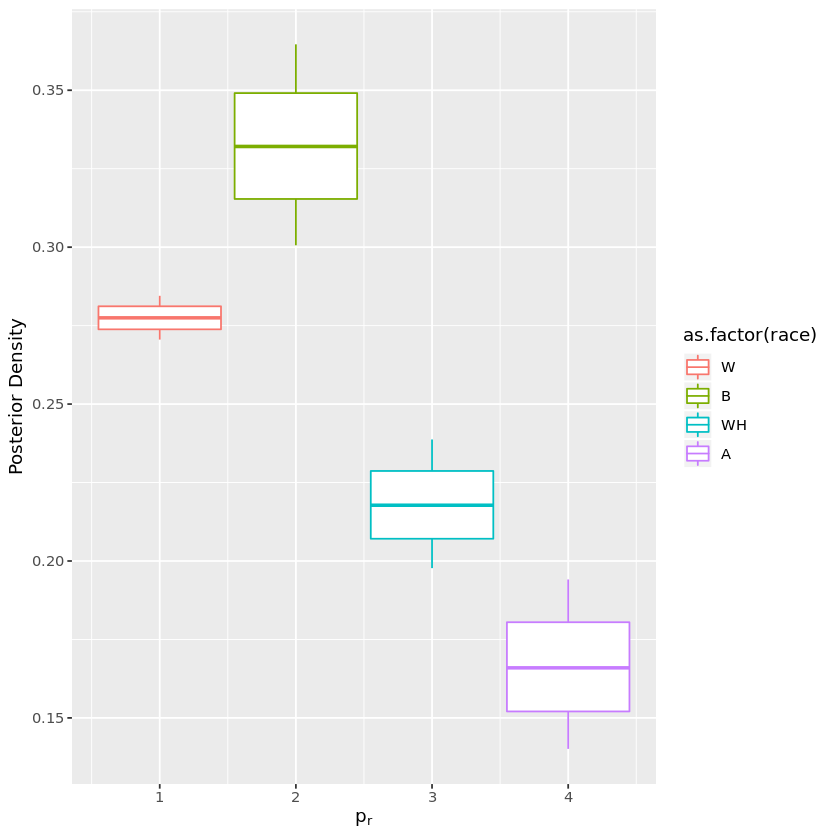

In [229]:
prob.muni.by.race = function(x,r){ dat %>%
                                       filter(raceethn==r) %>%
                                       select(rpt2.municipal.violation) %>%
                                       as.matrix %>%
                                       binom.posterior(x,.) %>%
                                       return }

p.w = prob.muni.by.race(.5,'W')
p.b = prob.muni.by.race(.5,'B')

print('Median bias detected:')
prob.muni.by.race(.5,'B') - prob.muni.by.race(.5,'W')
print('Median ratio to compensate for apparent bias:')
no.bias.at.probs(p.w,p.b)

plot.posterior(prob.muni.by.race)

So to compensate for the ~.5% bias in speeding stop rates Boulder PD would need to ignore speeding black drivers 8% more often than speeding white drivers. While 8% may not seem particularly large,  you need approximately 16x the bias *in the other direction* to compensate for the apparent bias. 

### Cruft

In [ ]:
dist.hellinger = function(outcome1,outcome2,pr.alpha=1,pr.beta=1){
    a1 = 1 + sum(outcome1)
    a2 = 1 + sum(outcome2)
    b1 = 1 + length(outcome1) - sum(outcome1)
    b2 = 1 + length(outcome2) - sum(outcome2)
    
    if (beta(a1,b1)*beta(a2,b2) == 0){return(1)} 
    else {}
    ret = 1 - beta( (a1+a2)/2, (b1+b2)/2 )/sqrt( beta(a1,b1) * beta(a2,b2) )
    return(ret)
}

dist.tv = function(outcome1,outcome2){
    p = seq(0,1,.05)
    pdf1 = binom.posterior.pdf(p, outcome1)
    pdf2 = binom.posterior.pdf(p, outcome2)
    
    pdf1 = pdf1/sum(pdf1)
    pdf2 = pdf2/sum(pdf2)
    
    diff.pdf = abs(pdf1 - pdf2)
    
    tv = -Inf
    for (n in 1:length(diff.pdf)){
        for( A in combn(diff.pdf,n) ){
            msr=sum(A)
            if (tv < msr){tv=msr}
            else {}
            
        }
    }
    
    tv %>% return
}

dist.bf = function(outcome1,outcome2){
    mod1.a1 = 1 + sum(outcome1)
    mod1.b1 = 1 + length(outcome1) - sum(outcome1)
    mod1.a2 = 1 + sum(outcome2)
    mod1.b2 = 1 + length(outcome2) - sum(outcome2)
    
    mod1.prD = choose(length(outcome1),sum(outcome1))*beta(mod1.a1,mod1.b1)*
            choose(length(outcome2),sum(outcome2))*beta(mod1.a2,mod1.b2)   
    
    outcome = c(outcome1,outcome2) 
    mod2.a = 1 + sum(outcome)
    mod2.b = 1 + length(outcome) - sum(outcome)
    
    mod2.prD = choose(length(outcome),sum(outcome))*beta(mod2.a,mod2.b) 

    return(mod1.prD/mod2.prD)       
}


pairwise.distance.comp = function(itemdesc, race.cutoff=400){ 
    races = dat %>% group_by(raceethn) %>% filter(n()>race.cutoff) %>% as.data.frame %>%
    select(raceethn) %>% unique %>% .[,1]
    races = c('W','B','WH','A','I')
    comp.pairs = expand.grid(races,races)
    
    hdists = c()
    for (i in 1:length(races)){
            for (j in i:length(races)){
                if (i==j){next}
                race1 = races[i]
                race2 = races[j]
                outcome1 = dat %>% filter(raceethn==race1) %>% select(itemdesc) %>% unlist
                outcome2 = dat %>% filter(raceethn==race2) %>% select(itemdesc) %>% unlist
    
                hdists %<>% append( posterior.bf(outcome1,outcome2) )
            }
        }    
    hdists %>% mean %>% return    
}

#### Do equipment violations end with more bad outcomes for PoC?

Using quantiles as value column: use value.var to override.


Using quantiles as value column: use value.var to override.


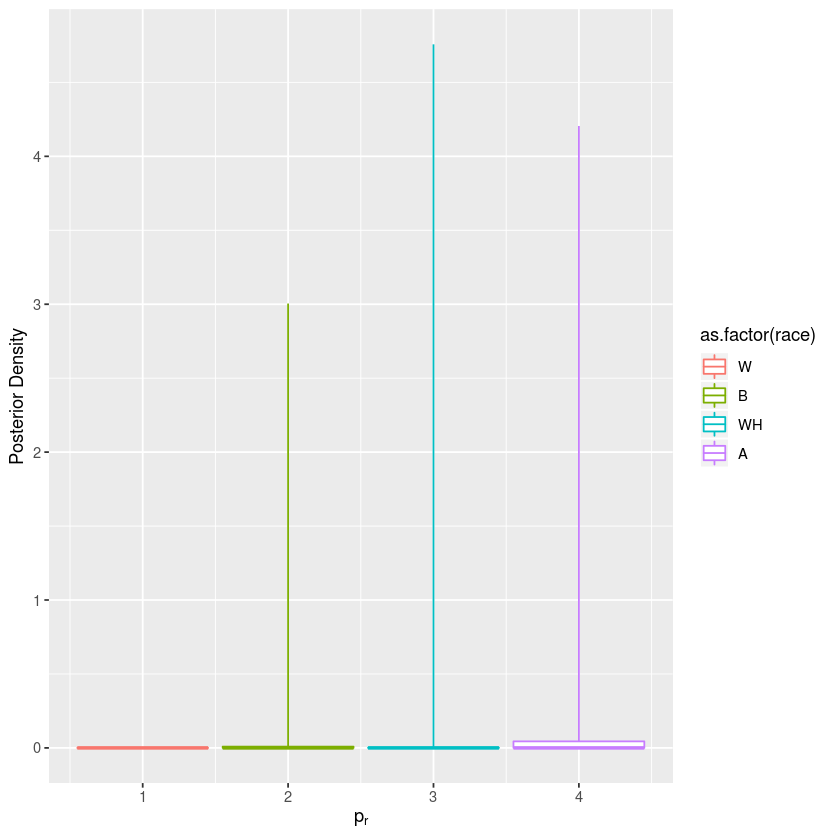

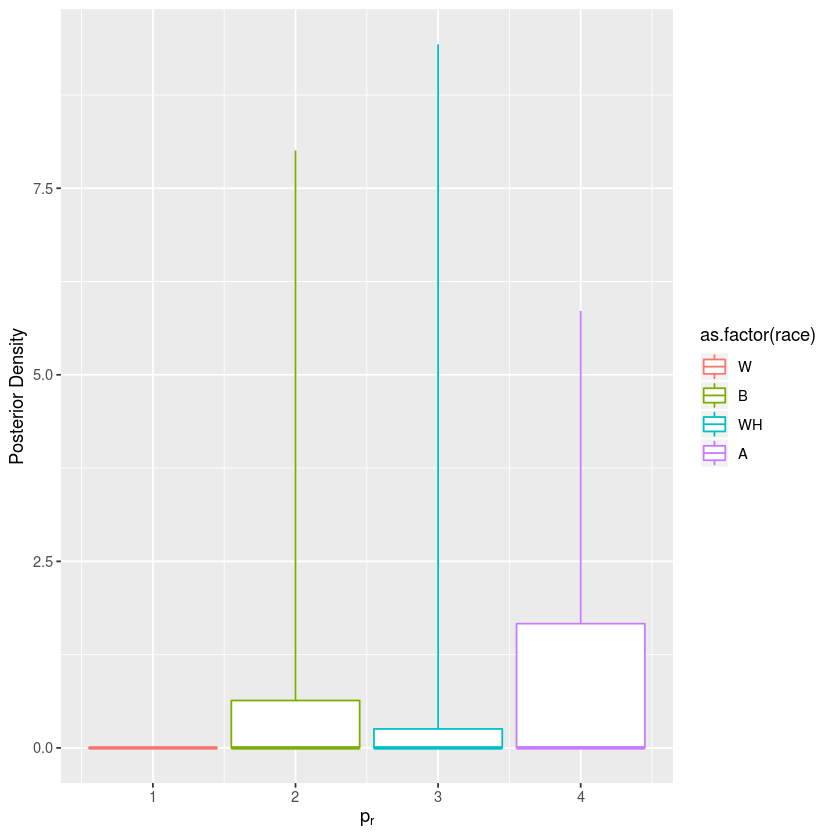

In [26]:
prob.arrested.given.equip.viol = function(x,r){ dat %>%
                                           filter(raceethn==r & rpt2.equipment.violation==1) %>%
                                           select(rpt6.arrest) %>%
                                           as.matrix %>%
                                           unif.beta.updated(x,.) %>%
                                           return }

prob.searched.given.equip.viol = function(x,r){ dat %>%
                                               filter(raceethn==r & rpt2.equipment.violation==1) %>%
                                               mutate(rpt3.search=not(rpt3.no.search|rpt3..no.search) ) %>%
                                               select(rpt3.search) %>%
                                               as.matrix %>%
                                               unif.beta.updated(x,.) %>%
                                               return }


plot.posterior(prob.arrested.given.equip.viol)
plot.posterior(prob.searched.given.equip.viol)